In [14]:
import uproot3 as up3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("../")
from src.data import load_root_file

# Background
* Study the background events
* For now : cut 0 tracks 1 shower
* study angles -> can we use $cos(\theta_\text{NuMI})$ again?

In [3]:
CUT_SHOWERS = 1
CUT_TRACKS = 0

vars = ['reco_asso_showers', 'reco_asso_tracks', 'reco_shower_dirx', 'reco_shower_diry', 'reco_shower_dirz', 'reco_shower_energy_max']
bkg_path = "../data/root/background/"

def cuts(df):
    # for now, 0 tracks, 1 shower
    df = df[df['reco_asso_showers'] == CUT_SHOWERS]
    df = df[df['reco_asso_tracks'] == CUT_TRACKS]
    return df


bkg_incryo_df = pd.concat([load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;269'), 
                          load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;268')])
bkg_dirt_df = pd.concat([load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;127'),
                        load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;126')])
bkg_beamoff_df = load_root_file("run1_NuMI_offbeam_full_set_sp.root", bkg_path, vars, cuts, 10_000, "singlephotonana")

bkg_total = pd.concat([bkg_incryo_df, bkg_dirt_df, bkg_beamoff_df])
display(bkg_total.head())

/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer e

In [27]:
print(len(bkg_incryo_df), len(bkg_dirt_df), len(bkg_beamoff_df))
# 15995 4897 4731

print(bkg_incryo_df.iloc[0]['reco_shower_dirx']**2+bkg_incryo_df.iloc[0]['reco_shower_diry']**2+bkg_incryo_df.iloc[0]['reco_shower_dirz']**2)

15995 4897 4731
0.9999998564896306


In [49]:
# translation and rotation from beamline coordinate system
# to detector coordinate system


def rotate_to_microboone(v : np.array) -> np.array:
    det_rot = np.array([[0.92103853804025682, 0.0000462540012621546684, -0.38947144863934974],
                        [0.0227135048039241207, 0.99829162468141475, 0.0538324139386641073],
                        [0.38880857519374290, -0.0584279894529063024, 0.91946400794392302]])
    # rotation
    #print(det_rot @ det_rot.T)
    v = np.dot(det_rot, v)
    return v

def translate_to_microboone(v : np.array):
    det_centre = np.array([55.02, 72.59,  672.70])
    return v + det_centre

rotate_to_microboone(np.array([1, 0, 0]))

array([0.92103854, 0.0227135 , 0.38880858])

In [50]:
# get the signal data
sig_path = "../data/root/BdNMC/"
# for now, concat all scalar and concat all sig?
dm_types = ["scalar", "fermion"]

sig_scalar_df = pd.DataFrame()
sig_fermion_df = pd.DataFrame()

for dm in dm_types:
    for file in os.listdir(sig_path + dm):
        if file.endswith(".root"):
            # get the approx shower dir with the electron momentum
            try:
                df = up3.open(sig_path + dm + "/" + file)["elecron_tree"].pandas.df()
            except:
                print("Error with file:", file)
                continue
            px, py, pz = df["electron_px"], df["electron_py"], df["electron_pz"]

            px, py, pz = rotate_to_microboone(np.array([px, py, pz]))
            # get the direction vector
            v = np.array([px, py, pz])
            # normalize
            v = v / np.linalg.norm(v)

            v_numi=np.array([0.462372, 0.0488541, 0.885339])
            v_shwr = np.array([v[0], v[1], v[2]])
            df["cos_theta_numi"] = np.dot(v_shwr.T, v_numi)

            meson, _, _, ma, _, dt = file.split("_")
            dt = dt.split(".")[0]

            if dm == "scalar":
                df["meson"] = meson
                df["ma"] = ma
                df["dt"] = dt
                sig_scalar_df = pd.concat([sig_scalar_df, df])
            
            elif dm == "fermion":
                df["meson"] = meson
                df["ma"] = ma
                df["dt"] = dt
                sig_fermion_df = pd.concat([sig_fermion_df, df])
            
            else:
                print("???")

display(sig_scalar_df.head())
display(sig_fermion_df.head())

Error with file: eta_fermion_ma_0.06_dt_0.33.root
Error with file: eta_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.05_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.33.root
Error with file: pi0_fermion_ma_0.01_dt_0.33.root
Error with file: eta_fermion_ma_0.07_dt_0.33.root
Error with file: pi0_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.09_dt_0.33.root
Error with file: pi0_fermion_ma_0.02_dt_0.33.root
Error with file: eta_fermion_ma_0.08_dt_0.33.root
Error with file: pi0_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.6.root
Error with file: eta_fermion_ma_0.1_dt_0.33.root
Error with file: eta_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.02_dt_0.33.root


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,4228,0.016976,0.003058,0.007342,0.014989,3.617416,3.404363,442.111274,1.491252e-06,0.0,0.002510,pi0,0.01,0
1,15742,0.120360,0.004236,0.021493,0.118348,64.687432,83.100212,775.618698,2.624276e-06,0.0,0.016598,pi0,0.01,0
2,33531,0.021046,-0.001036,0.005552,0.020268,10.909725,14.620994,135.967147,4.711300e-07,0.0,0.002554,pi0,0.01,0
3,50363,0.007655,0.002873,0.000636,0.007049,2.860501,4.569110,528.785534,1.783378e-06,0.0,0.001416,pi0,0.01,0
4,61115,0.138806,0.012813,0.004086,0.138152,54.291919,73.903909,679.985285,2.302073e-06,0.0,0.020671,pi0,0.01,0


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,11543,0.026064,0.001621,0.006102,0.025282,3.704154,5.069224,47.291694,1.730464e-07,0.0,0.004005,pi0,0.01,0
1,27236,0.133683,0.020038,0.009201,0.131851,81.167907,113.500560,995.149240,3.368569e-06,0.0,0.022968,pi0,0.01,0
2,30186,0.015036,0.004107,0.003982,0.013896,83.915060,112.565461,1032.340790,3.488571e-06,0.0,0.002774,pi0,0.01,0
3,32613,0.044638,-0.001245,0.000787,0.044611,87.405790,113.115681,1038.272521,3.510960e-06,0.0,0.006342,pi0,0.01,0
4,36420,0.146395,0.018815,0.022900,0.143363,39.389583,55.031354,516.981491,1.752562e-06,0.0,0.024435,pi0,0.01,0


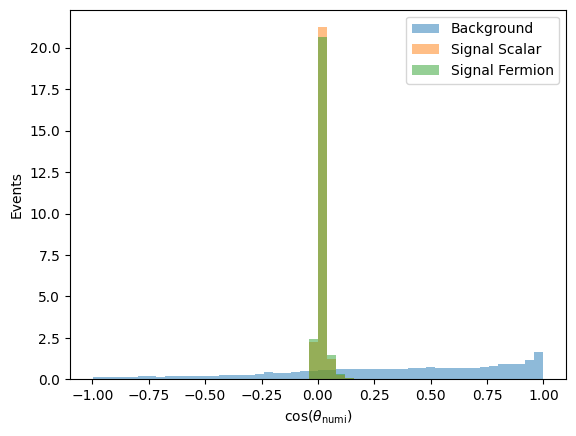

In [51]:
# Now get the directional distributions of these events.
# lets use cos(theta_numi), as that worked well last time
# should check cos(theta_numi) for the signal events too

fig = plt.figure()
ax = fig.add_subplot(111)
_, bins, _ =ax.hist(bkg_total['cos_theta_numi'], bins=50, alpha=0.5, label='Background', density=True)
ax.hist(sig_scalar_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Scalar', density=True)
ax.hist(sig_fermion_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Fermion', density=True)

ax.set(xlabel=r"$\cos(\theta_{\text{numi}})$", ylabel="Events")
ax.legend()
plt.show()